In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

In [3]:
df_raw = pd.read_pickle("../data/GBP_JPY_H1.pkl")

In [4]:
df_raw.shape

(37224, 14)

In [10]:
df_an = df_raw.iloc[-6000:].copy()
df_an.reset_index(drop=True, inplace=True)

In [11]:
df_an.shape

(6000, 14)

In [12]:
df_an = RSI(df_an)

In [14]:
df_an.tail()

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,RSI_14
5995,2021-12-30 19:00:00+00:00,721,155.312,155.444,155.274,155.444,155.296,155.432,155.260,155.432,155.328,155.458,155.289,155.457,61.286263
5996,2021-12-30 20:00:00+00:00,1001,155.442,155.470,155.289,155.312,155.429,155.458,155.275,155.298,155.456,155.484,155.303,155.326,55.345932
5997,2021-12-30 21:00:00+00:00,638,155.317,155.382,155.286,155.382,155.301,155.362,155.270,155.362,155.333,155.404,155.300,155.402,57.688104
5998,2021-12-30 22:00:00+00:00,623,155.353,155.381,155.282,155.329,155.278,155.315,155.207,155.254,155.428,155.456,155.357,155.404,55.322082
5999,2021-12-30 23:00:00+00:00,419,155.336,155.360,155.284,155.310,155.262,155.329,155.262,155.294,155.411,155.418,155.299,155.327,54.459758


In [15]:
df_an = apply_patterns(df_an)

In [16]:
df_an['EMA_200'] = df_an.mid_c.ewm(span=200, min_periods=200).mean()

In [17]:
df_an.columns

Index(['time', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h',
       'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'RSI_14',
       'body_lower', 'body_upper', 'body_bottom_perc', 'body_top_perc',
       'body_perc', 'direction', 'body_size', 'low_change', 'high_change',
       'body_size_change', 'mid_point', 'mid_point_prev_2', 'body_size_prev',
       'direction_prev', 'direction_prev_2', 'body_perc_prev',
       'body_perc_prev_2', 'HANGING_MAN', 'SHOOTING_STAR', 'SPINNING_TOP',
       'MARUBOZU', 'ENGULFING', 'TWEEZER_TOP', 'TWEEZER_BOTTOM',
       'MORNING_STAR', 'EVENING_STAR', 'EMA_200'],
      dtype='object')

In [24]:
our_cols = ['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 
            'ask_c', 'bid_c', 'ENGULFING', 'direction', 'EMA_200', 'RSI_14']

In [25]:
df_slim = df_an[our_cols].copy()
df_slim.dropna(inplace=True)
df_slim.reset_index(drop=True, inplace=True)

In [26]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14
0,2021-01-27 05:00:00+00:00,142.404,142.499,142.399,142.490,142.503,142.478,True,1,141.854528,67.293687
1,2021-01-27 06:00:00+00:00,142.488,142.496,142.402,142.476,142.490,142.463,False,-1,141.861668,66.115829
2,2021-01-27 07:00:00+00:00,142.474,142.663,142.426,142.596,142.608,142.583,True,1,141.870092,70.828951
3,2021-01-27 08:00:00+00:00,142.594,142.626,142.365,142.512,142.523,142.502,False,-1,141.877445,64.106935
4,2021-01-27 09:00:00+00:00,142.510,142.612,142.411,142.555,142.565,142.545,False,1,141.885195,65.891472


In [28]:
BUY = 1
SELL = -1
NONE = 0
RSI_LIMIT = 50.0

def apply_signal(row):
    if row.ENGULFING == True:
        if row.direction == BUY and row.mid_l > row.EMA_200:
            if row.RSI_14 > RSI_LIMIT:
                return BUY
        if row.direction == SELL and row.mid_h < row.EMA_200:
            if row.RSI_14 < RSI_LIMIT:
                return SELL
    return NONE

In [29]:
df_slim["SIGNAL"] = df_slim.apply(apply_signal, axis=1)

In [30]:
df_slim["SIGNAL"].value_counts()

SIGNAL
 0    5252
 1     337
-1     212
Name: count, dtype: int64

In [32]:
LOSS_FACTOR = -1.0
PROFIT_FACTOR = 1.5

def apply_take_profit(row):
    if row.SIGNAL != NONE:
        return (row.mid_c - row.mid_o) * PROFIT_FACTOR + row.mid_c
    else:
        return 0.0

def apply_stop_loss(row):
    if row.SIGNAL != NONE:
        return row.mid_o
    else:
        return 0.0

In [34]:
df_slim["TP"] = df_slim.apply(apply_take_profit, axis=1)
df_slim["SL"] = df_slim.apply(apply_stop_loss, axis=1)

In [37]:
df_slim[df_slim.SIGNAL==BUY].head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL
0,2021-01-27 05:00:00+00:00,142.404,142.499,142.399,142.490,142.503,142.478,True,1,141.854528,67.293687,1,142.619,142.404
2,2021-01-27 07:00:00+00:00,142.474,142.663,142.426,142.596,142.608,142.583,True,1,141.870092,70.828951,1,142.779,142.474
8,2021-01-27 13:00:00+00:00,142.304,142.433,142.222,142.402,142.413,142.390,True,1,141.908646,54.159414,1,142.549,142.304
10,2021-01-27 15:00:00+00:00,142.380,142.726,142.364,142.650,142.661,142.638,True,1,141.922321,64.072976,1,143.055,142.380
12,2021-01-27 17:00:00+00:00,142.492,142.724,142.466,142.704,142.716,142.692,True,1,141.937515,62.708642,1,143.022,142.492


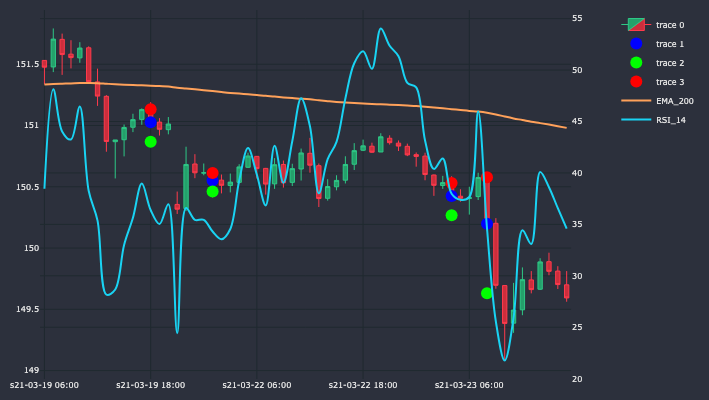

In [40]:
df_plot = df_slim.iloc[890:950]
cp = CandlePlot(df_plot, candles=True)

trades = cp.df_plot[cp.df_plot.SIGNAL != NONE]

markers = ['mid_c', 'TP', 'SL']
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

for i in range(3):
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime,
        y = trades[markers[i]],
        mode = 'markers',
        marker=dict(color=marker_colors[i], size=12)
    ))

cp.show_plot(line_traces=["EMA_200"], sec_traces=['RSI_14'])

In [42]:
class Trade:
    def __init__(self, row):
        self.running = True

    def close_trade(self, row):
        pass
    
    def update(self, row):
        pass

In [43]:
open_trades = []
closed_trades = []

for index, row in df_slim.iterrows():
    for ot in open_trades:
        ot.update(row)
        if ot.running == False:
            closed_trades.append(ot)
    open_trades = [x for x in open_trades if x.running == True]

    if row.SIGNAL != NONE:
        pass # add new trade